<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Helper-Functions" data-toc-modified-id="Helper-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Helper Functions</a></span></li><li><span><a href="#$M_{BH}---M_{star}$-Relation" data-toc-modified-id="$M_{BH}---M_{star}$-Relation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>$M_{BH} - M_{star}$ Relation</a></span></li><li><span><a href="#$M_{star}---M_{vir}$-Relation" data-toc-modified-id="$M_{star}---M_{vir}$-Relation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>$M_{star} - M_{vir}$ Relation</a></span></li><li><span><a href="#$\Sigma_e---M_{star}$-Relation" data-toc-modified-id="$\Sigma_e---M_{star}$-Relation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>$\Sigma_e - M_{star}$ Relation</a></span></li><li><span><a href="#Plot-comparisons" data-toc-modified-id="Plot-comparisons-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plot comparisons</a></span></li><li><span><a href="#$E_{BH}---E_{SN}$-Relation" data-toc-modified-id="$E_{BH}---E_{SN}$-Relation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>$E_{BH} - E_{SN}$ Relation</a></span></li></ul></div>

In [362]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [363]:
data = pd.read_hdf('./Data/data_product.hdf')
history = pd.read_hdf('./Data/history_product.hdf')

## Helper Functions

In [364]:
def partial_derivative(func, x, var=0, point=[]):
    '''
    Returns the partial derivative of func wrt the nth variable at the given point, but not wrt x.
    '''
    from scipy.misc import derivative
    args = point[:]
    def wraps(a):
        args[var] = a
        return func(x, *args)
    return derivative(wraps, point[var], dx = 1e-8)

def sigma(func, x, params, variances):
    '''
    Returns the total 1-sigma errors of a function given parameter values and their errors using partials.
    '''
    from numpy import sum, sqrt
    num_var = range(len(params))
    arg = [pow(partial_derivative(func, x, var=i, point=params),2) * variances[i] for i in num_var]
    return sqrt(sum(arg, axis=0))

def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None, hatch=None, edgecolor=None, **kwargs):
    ''' Plot a filled uncertainty/error region.
    '''
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin = y - yerr[0]
        ymax = y + yerr[1]
    ax.plot(x, y, color=color, **kwargs)
    if hatch is None:
        ax.fill_between(x, ymax, ymin, facecolor=color, alpha=alpha_fill, lw=1)
    else:
        ax.fill_between(x, ymax, ymin, facecolor='none', alpha=alpha_fill, hatch=hatch, edgecolor=edgecolor, lw=1)

def medianPerBin(X, Y, bins, err_type='std'):
    ''' Bin X-data and return the median of Y-data in each bin as well as the Y-errors in each bin.
    '''
    data = np.float64(Y)
    
    digitize = np.digitize(X, bins)
    median = np.array([np.nanmedian(data[digitize == j]) for j in range(1, len(bins)+1)])
    if err_type == "Poisson":
        errs = np.array([len(data[digitize == j]) for j in range(1, len(bins)+1)])
    elif err_type == 'std':
        errs = np.array([np.nanstd(data[digitize == j]) for j in range(1, len(bins)+1)])
    elif err_type == 'MAD':
        errs = []
        for j in range(1, len(bins)+1):
            yi = data[digitize == j]
            med = np.nanmedian(yi)
            errs += [np.nanmedian(abs(yi - med))]
        errs = np.array(errs) / 0.67449
    else:
        print('Invalid error type')
        return None
    return median, errs

## $M_{BH} - M_{star}$ Relation

We start by plotting the BH mass - stellar mass relation. We find that at dwarf masses ($M_{star} < 10^{10}$), there is a high degree of scatter in BH masses. We categorize (somewhat arbitrarily) BH masses into overmassive/undermassive according to the 75th and 25th percentile in each stellar mass bin. We compare our relation to observational results from Reines+ (2015) and Schramm+ (2013).

In [128]:
def Reines15AGN(mstar, a=7.45, b=1.05):  # Reines & Volonteri (2015) AGN only
    return a + b * (mstar - 11)

def Reines15(mstar, a=8.95, b=1.40):  # Reines & Volonteri (2015) Elliptical/Spiral
    return a + b * (mstar - 11)

def SchrammSilverman13(Mstar): #Schramm & Silverman 2013
    return 1.12*(Mstar - 11.) + 8.30

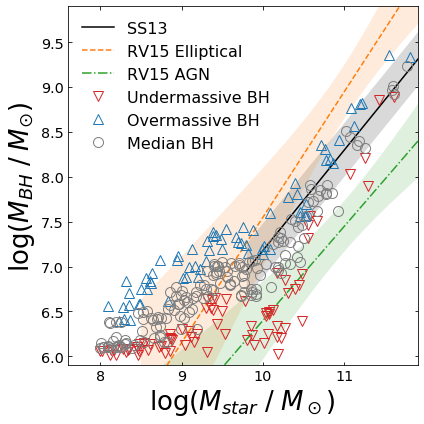

In [312]:
f, ax = plt.subplots(1,1, figsize=(6,6))

classBH = ['undermassive', 'overmassive', 'nominal']
labels = ['Undermassive BH', 'Overmassive BH', 'Median BH']
colors = ['C3v', 'C0^', 'C7o']

Mrange = np.linspace(9.8, 12, 50)
errorfill(Mrange, SchrammSilverman13(Mrange), 0.3 * np.ones(Mrange.shape), color='k', ax=ax, alpha_fill=0.15, ls='-', label=r'SS13')
Mrange = np.linspace(8.5, 12, 50)
errorfill(Mrange, Reines15(Mrange), sigma(Reines15, Mrange, [8.95,1.40],[0.09,0.21]), color='C1', ls='--', ax=ax, alpha_fill=0.15, label='RV15 Elliptical')
errorfill(Mrange, Reines15AGN(Mrange), sigma(Reines15AGN, Mrange, [7.45,1.05],[0.08,0.11]), color='C2', ls='-.', ax=ax, alpha_fill=0.15, label='RV15 AGN')

for i in range(len(classBH)):
    cl = classBH[i]
    X = data.query('classBH == @cl')
    ax.plot(X.Mstar.values, X.Mbh.values, colors[i], mfc='none', ms=10, label=labels[i])

ax.legend(loc=2, fontsize=16, frameon=False)
ax.set_ylim(5.9, 9.9)
ax.set_xlim(7.6, 11.9)
ax.set_xlabel(r'$\log(M_{star}\;/\;M_\odot)$', fontsize=26)
ax.set_ylabel(r'$\log(M_{BH}\;/\;M_{\odot})$', fontsize=26)
f.tight_layout()
f.savefig('Figures/Mbh-Mstar.png', bbox_inches='tight')

We can trace the evolution of our dwarf galaxies through the BH mass - stellar mass plane. We find that undermassive BHs and their hosts follow a different evolutionary path than their overmassive counterparts. Undermassive BHs grow after their host galaxy builds up its stellar mass. On the contrary, overmassive BHs grow before stellar mass builds up.

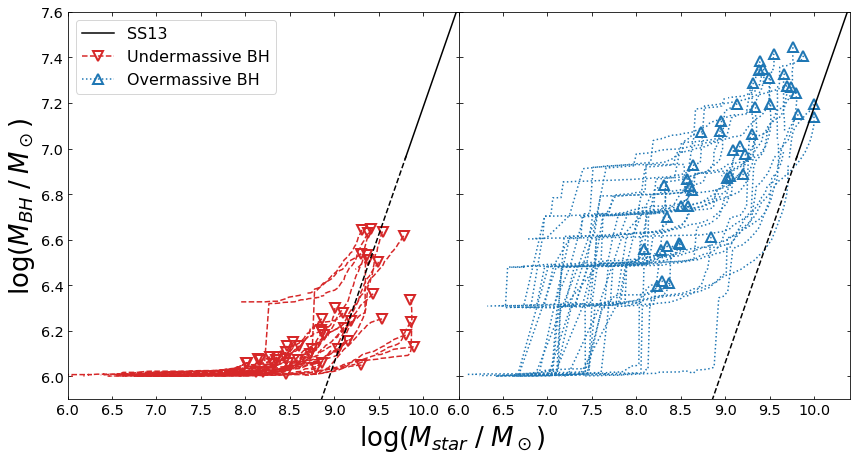

In [311]:
f, axes = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True, gridspec_kw = {'wspace':0, 'hspace':0})

classBH = ['undermassive', 'overmassive']
labels = ['Undermassive BHs', 'Overmassive BHs']
colors = ['C3', 'C0']
markers = ['v', '^']
linestyles = ['--', ':']

for i in range(len(classBH)):
    ax = axes.flat[i]
    cl = classBH[i]
    label = labels[i]
    color = colors[i]
    marker = markers[i]
    ls = linestyles[i]
    
    X = data.query('Mstar < 10 and classBH == @cl')
    X1 = X.Mstar.values
    Y1 = X.Mbh.values
    ax.plot(X1, Y1, marker=marker, color=color, ls='None', ms=10, mfc='None', mew=2)
    
    for h in X.halo_num:
        X2 = history[h].Mstar.values
        Y2 = history[h].Mbh.values
        ax.plot(X2, Y2, color=color, ls=ls)
    
    Mrange = np.linspace(8.5, 9.81, 50)
    ax.plot(Mrange, SchrammSilverman13(Mrange), 'k--')

    Mrange = np.linspace(9.8, 10.5, 50)
    ax.plot(Mrange, SchrammSilverman13(Mrange), 'k-', label='SS13')
    
    ax.set_ylim(5.9,7.6)
    ax.set_xlim(6,10.4)


axes.flat[0].plot([], [], color='C3', marker='v', ls='--', label='Undermassive BH', mfc='None', mew=2, ms=10)
axes.flat[0].plot([], [], color='C0', marker='^', ls=':', label='Overmassive BH', mfc='None', mew=2, ms=10)
axes.flat[0].legend(loc=2, fontsize=16)
axes.flat[0].set_ylabel(r'$\log(M_{BH}\;/\;M_\odot)$', fontsize=26)
f.text(0.42, -0.04, r'$\log(M_{star}\;/\;M_\odot)$', fontsize=26)

f.tight_layout()
f.savefig('Figures/Mbh-Mstar-evolution.png', bbox_inches='tight')

## $M_{star} - M_{vir}$ Relation

Next we turn to the stellar mass - halo mass relation for dwarf galaxies. In scenarios with significant feedback, we expect to see a suppression of stellar mass relative to halo mass. The Romulus25 relation follows abundance matching estimates (see Tremmel+ (2017) for details). We find that above $M_{star} > 10^{9}$, hosts of overmassive BHs tend to show less stellar mass than expected for their halo mass.

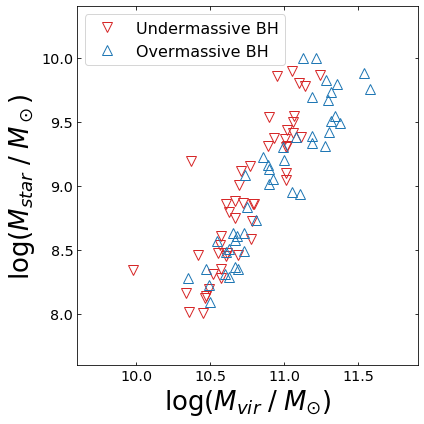

In [310]:
f, ax = plt.subplots(1,1, figsize=(6,6))

classBH = ['undermassive', 'overmassive']
labels = ['Undermassive BH', 'Overmassive BH', 'Median BH']
colors = ['C3v', 'C0^', 'C7o']
for i in range(len(classBH)):
    cl = classBH[i]
    color = colors[i]
    label = labels[i]
    X = data.query('Mstar < 10 and classBH == @cl')

    X1 = X.Mvir
    Y1 = X.Mstar
    ax.plot(X1, Y1, color, mfc='none', ms=10, label=label)

ax.set_xlim(9.6,11.9)
ax.set_ylim(7.6,10.4)
ax.set_ylabel(r'$\log(M_{star}\;/\;M_\odot)$', fontsize=26)
ax.set_xlabel(r'$\log(M_{vir}\;/\;M_{\odot})$', fontsize=26)
ax.legend(loc=2, fontsize=16)
f.tight_layout()
f.savefig('Figures/Mstar-Mvir.png', bbox_inches='tight')

## $\Sigma_e - M_{star}$ Relation

Next we turn to the central stellar surface density - stellar mass relation. The central density is calculated as the surface density of stars within the stellar effective radius. The effective radius is obtained through fitting Sersic profiles to V-band surface brightness profiles with a cutoff of 32 mag arcsec$^{-2}$. This relation is well-studied in massive galaxies as an indicator of feedback suppressing star formation (see Barro+ (2016), Choi+ (2018) and references therein). Here we find a similar effect of central density suppression for overmassive BH hosts above $M_{star} > 10^{9.5}$.

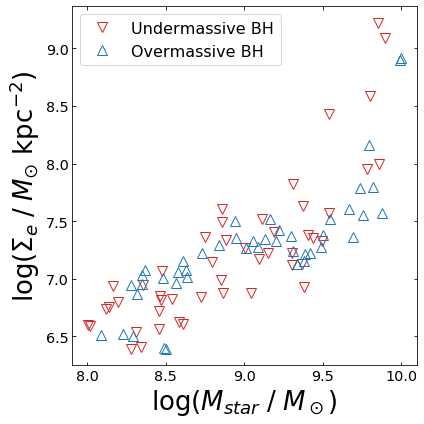

In [365]:
f, ax = plt.subplots(1,1, figsize=(6,6))

classBH = ['undermassive', 'overmassive']
labels = ['Undermassive BH', 'Overmassive BH', 'Median BH']
colors = ['C3v', 'C0^', 'C7o']
lcolors = ['C3-', 'C0--', 'C7:']

for i in range(len(classBH)):
    cl = classBH[i]
    color = colors[i]
    lcolor = lcolors[i]
    label = labels[i]
    X = data.query('Mstar < 10 and classBH == @cl')
    X1 = X.Mstar
    Y1 = np.log10([history[h].sigma_estars[0] for h in X.halo_num])
    ax.plot(X1, Y1, color, ms=10, label=label, mfc='none')
        
ax.legend(loc=2, fontsize=16)
ax.set_xlabel(r'$\log(M_{star}\;/\;M_\odot)$', fontsize=26)
ax.set_ylabel(r'$\log(\Sigma_e\;/\;M_{\odot}$ kpc$^{-2})$', fontsize=26)
f.tight_layout()
f.savefig('Figures/SigmaE-Mstar.png', bbox_inches='tight')

We also follow the growth of central stellar density through time. Overmassive BH hosts that reach $M_{star} > 10^{9.5}$ by $z=0$ have their central density growth suppressed. Their undermassive BH counterparts continue growing. By $z=0$, undermassive BH hosts are $\sim$1 dex higher in central density.

/home/ray/anaconda3/envs/paper1/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


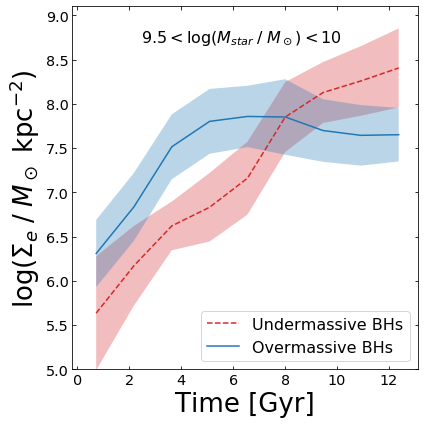

In [325]:
f, ax = plt.subplots(1,1, figsize=(6,6))
classBH = ['undermassive', 'overmassive']
labels = ['Undermassive BHs', 'Overmassive BHs']
colors = ['C3', 'C0']
linestyles = ['--', '-']
bins = np.linspace(0,13.1,10)

for i in range(len(classBH)):
    cl = classBH[i]
    color = colors[i]
    ls = linestyles[i]
    label = labels[i]
    X = data.query('9.5 < Mstar < 10 and classBH == @cl')

    X1 = np.array([history[h].time.values for h in X.halo_num])
    Y1 = np.array([history[h].sigma_estars.values for h in X.halo_num])
    median, errs = medianPerBin(X1, Y1, bins, err_type='MAD')
    errorfill(bins+np.diff(bins)[0]/2, np.log10(median), errs/median/np.log(10), color=color, ax=ax, ls=ls, label=label)
    
    ax.set_ylim(5,9.1)
    ax.set_xlim(-0.2,13.1)

ax.text(0.2,0.9, r'$9.5 < \log(M_{star}\;/\;M_\odot) < 10$', fontsize=16, transform=ax.transAxes)
ax.set_ylabel(r'$\log(\Sigma_e\;/\;M_\odot$ kpc$^{-2})$', fontsize=26)
ax.set_xlabel('Time [Gyr]', fontsize=26)
ax.legend(loc=4, fontsize=16)
f.tight_layout()
f.savefig('Figures/SigmaE-time.png', bbox_inches='tight')

## Plot comparisons

Here are all of our X vs stellar mass relations.

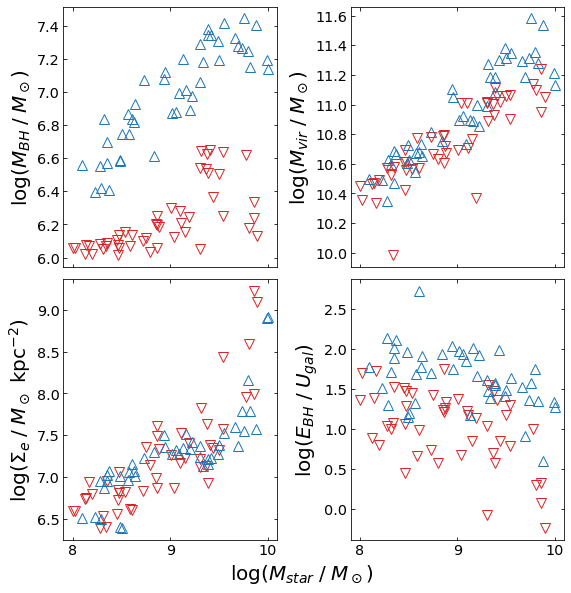

In [359]:
f, axes = plt.subplots(2,2, figsize=(8,8), sharex=True)

classBH = ['undermassive', 'overmassive']
labels = ['Undermassive BH', 'Overmassive BH', 'Median BH']
colors = ['C3v', 'C0^', 'C7o']
lcolors = ['C3-', 'C0--', 'C7:']

for j in range(len(axes.flat)):
    ax = axes.flat[j]
    for i in range(len(classBH)):
        cl = classBH[i]
        color = colors[i]
        lcolor = lcolors[i]
        label = labels[i]
        X = data.query('Mstar < 10 and classBH == @cl')
        X1 = X.Mstar
        if j == 0:
            Y1 = X.Mbh
            label = r'$\log(M_{BH}\;/\;M_\odot)$'
        if j == 1:
            Y1 = X.Mvir
            label = r'$\log(M_{vir}\;/\;M_\odot)$'
        if j == 2:
            Y1 = np.log10([history[h].sigma_estars[0] for h in X.halo_num])
            label = r'$\log(\Sigma_{e}\;/\;M_\odot$ kpc$^{-2})$'
        if j == 3:
            Re = np.array([history[h].Re.values[0] for h in X.halo_num])
            M_Re = np.array([history[h].M_re.values[0] for h in X.halo_num])
            Y1 = np.log10(X.EBH/Ugal(M_Re, Re))
            label = r'$\log(E_{BH}\;/\;U_{gal})$'
        ax.plot(X1, Y1, color, ms=10, label=label, mfc='none')

        ax.set_ylabel(label, fontsize=20)
        
f.text(0.4,-0.02, r'$\log(M_{star}\;/\;M_\odot)$', fontsize=20)
f.tight_layout()
f.savefig('Figures/Relations-Mstar.png', bbox_inches='tight')

We also follow the same analysis with halo mass and, unsurprisingly, find similar results.

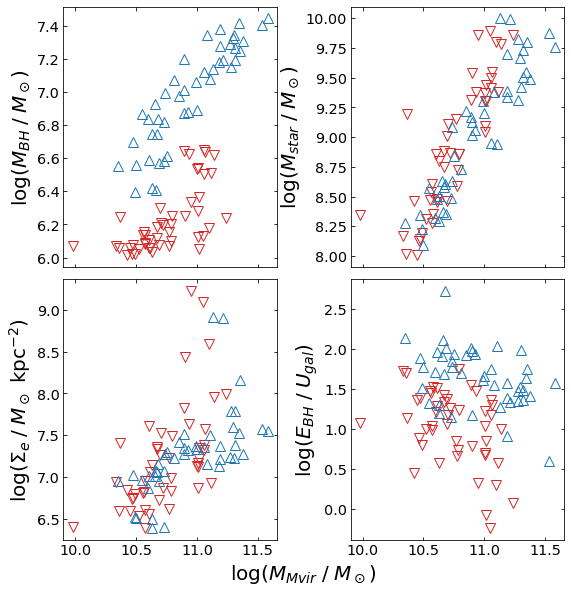

In [367]:
f, axes = plt.subplots(2,2, figsize=(8,8), sharex=True)

classBH = ['undermassive', 'overmassive']
labels = ['Undermassive BH', 'Overmassive BH', 'Median BH']
colors = ['C3v', 'C0^', 'C7o']
lcolors = ['C3-', 'C0--', 'C7:']

for j in range(len(axes.flat)):
    ax = axes.flat[j]
    for i in range(len(classBH)):
        cl = classBH[i]
        color = colors[i]
        lcolor = lcolors[i]
        label = labels[i]
        X = data.query('Mstar < 10 and classBH == @cl')
        X1 = X.Mvir
        if j == 0:
            Y1 = X.Mbh
            label = r'$\log(M_{BH}\;/\;M_\odot)$'
        if j == 1:
            Y1 = X.Mstar
            label = r'$\log(M_{star}\;/\;M_\odot)$'
        if j == 2:
            Y1 = np.log10([history[h].sigma_estars[0] for h in X.halo_num])
            label = r'$\log(\Sigma_{e}\;/\;M_\odot$ kpc$^{-2})$'
        if j == 3:
            Re = np.array([history[h].Re.values[0] for h in X.halo_num])
            M_Re = np.array([history[h].M_re.values[0] for h in X.halo_num])
            Y1 = np.log10(X.EBH/Ugal(M_Re, Re))
            label = r'$\log(E_{BH}\;/\;U_{gal})$'
        ax.plot(X1, Y1, color, ms=10, label=label, mfc='none')

        ax.set_ylabel(label, fontsize=20)
        
f.text(0.4,-0.02, r'$\log(M_{Mvir}\;/\;M_\odot)$', fontsize=20)
f.tight_layout()
f.savefig('Figures/Relations-Mvir.png', bbox_inches='tight')

## $E_{BH} - E_{SN}$ Relation

Finally, we assess the ability of BHs to have effects on the evolution of dwarf galaxies. We plot the total energy injected by BHs versus SNe, relative to the binding energy of the galaxy at the effective radius. The 1-1 line is plotted. We find that overmassive BH hosts are often dominated by BH energy injection while undermassive BH hosts are dominated by SN energy injection.

In [6]:
def Ugal(M, R):
    return (3/5) * 8.55e37 * M**2 / R

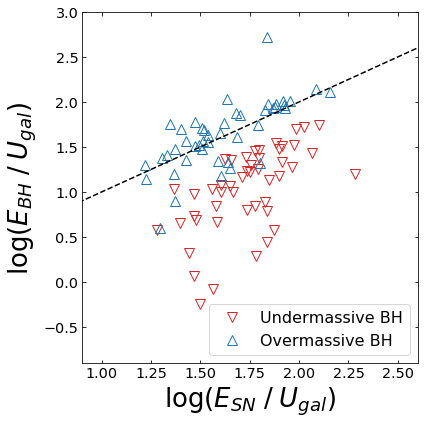

In [302]:
f, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True, sharey=True)

classBH = ['undermassive','overmassive']
labels = ['Undermassive BH', 'Overmassive BH', 'Nominal BH']
facecolors = ['None', None]
styles = ['C3v', 'C0^', 'C7o']
colors = ['C3', 'C0', 'C7']

for i in range(len(classBH)):
    cl = classBH[i]
    style = styles[i]
    X = data.query('Mstar < 10 and classBH == @cl')
    
    Re = np.array([history[h].Re.values[0] for h in X.halo_num])
    M_Re = np.array([history[h].M_re.values[0] for h in X.halo_num])
    Z1 = np.log10(Ugal(M_Re, Re))
    Y1 = np.log10(X.EBH) - Z1
    X1 = np.log10(X.ESN) - Z1

    ax.plot(X1, Y1, style, mfc='none', ms=10, label=labels[i])
        
Erange = np.linspace(0,5,51)
ax.plot(Erange, Erange, 'k--')
ax.set_ylim(-0.9,3)
ax.set_xlim(0.9, 2.6)
ax.set_ylabel(r'$\log(E_{BH}\;/\;U_{gal})$', fontsize=26)
ax.set_xlabel(r'$\log(E_{SN}\;/\;U_{gal})$', fontsize=26)
ax.legend(loc=4, fontsize=16)
f.tight_layout()
f.savefig('Figures/EBH-ESN.png', bbox_inches='tight')